# Feature analysis and extraction

This notebooks contain a more detailed analysis of each column.
For each column of the table, we'll try to assess the type of distribution
(e.g. does it fit a Gaussian?).
Then we'll create as many features as possible accordingly
(e.g. one column could lend itself to both a numerical feature and
a binary or categorical feature).

### Read the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

In [2]:
sns.set()

Read the data:

In [3]:
orders_table = pd.read_json(
    "../data/orders_table_dtypes.json",
    orient='table',
)

Both time-series and values distribution can be useful for building features so we'll focus on both.

In [4]:
orders_table.head()

,customer_id,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id,order_datetime
0,000097eabfd9,1,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356,2015-06-20 19:00:00
1,0000e2c6d9be,1,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356,2016-01-29 20:00:00
2,000133bb597f,1,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324,2017-02-26 19:00:00
3,00018269939b,1,0,0.0,0.493,9.82350,36613498,99315,1619,30359,4356,2017-02-05 17:00:00
4,0001a00468a6,1,0,0.0,0.493,5.15070,225853498,16456,1619,29463,4356,2015-08-04 19:00:00


In [5]:
orders_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786600 entries, 0 to 786599
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   customer_id          786600 non-null  object        
 1   customer_order_rank  786600 non-null  int64         
 2   is_failed            786600 non-null  int64         
 3   voucher_amount       786600 non-null  float64       
 4   delivery_fee         786600 non-null  float64       
 5   amount_paid          786600 non-null  float64       
 6   restaurant_id        786600 non-null  category      
 7   city_id              786600 non-null  category      
 8   payment_id           786600 non-null  category      
 9   platform_id          786600 non-null  category      
 10  transmission_id      786600 non-null  category      
 11  order_datetime       786600 non-null  datetime64[ns]
dtypes: category(5), datetime64[ns](1), float64(3), int64(2), object(1)
memor

### Time distribution

A quick look at the time distribution of data points (number of orders per day):

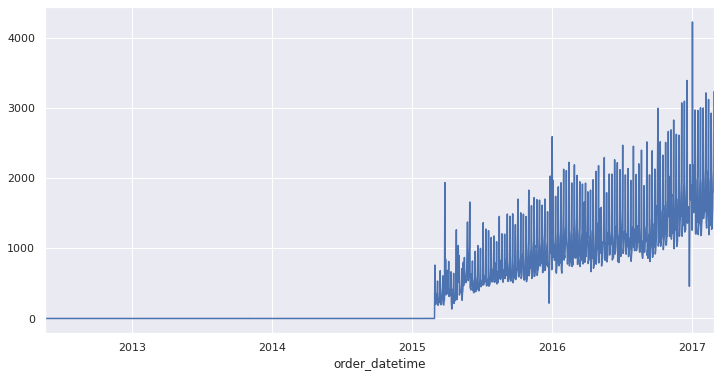

In [6]:
orders_table.set_index('order_datetime')['customer_id'].resample('D').count().plot(
    figsize=(12,6),
#     logy=True,
);

The data before March 2015 is very sparse.
This looks a bit suspect
and would require further investigation.

In practice, there is some missing data due to some issue in the data collection process.
This would require a double check with the owners of
the data source or the data preprocessing pipeline.
To be on the safe side and for the sake of time, we'll simply ignore all data before March 2015.

In [7]:
orders_table_orig = orders_table

In [8]:
orders_table = orders_table.set_index(
    'order_datetime'
).loc["2015-03-01":].reset_index()
orders_table

,order_datetime,customer_id,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id
0,2015-06-20 19:00:00,000097eabfd9,1,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356
1,2016-01-29 20:00:00,0000e2c6d9be,1,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356
2,2017-02-26 19:00:00,000133bb597f,1,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324
3,2017-02-05 17:00:00,00018269939b,1,0,0.0,0.493,9.82350,36613498,99315,1619,30359,4356
4,2015-08-04 19:00:00,0001a00468a6,1,0,0.0,0.493,5.15070,225853498,16456,1619,29463,4356
...,...,...,...,...,...,...,...,...,...,...,...,...
786542,2016-09-30 20:00:00,fffe9d5a8d41,0,1,0.0,0.000,10.72620,983498,10346,1779,29463,212
786543,2016-08-17 21:00:00,ffff347c3cfa,1,0,0.0,0.000,7.59330,52893498,41978,1619,30359,4356
786544,2016-09-15 21:00:00,ffff347c3cfa,2,0,0.0,0.000,5.94720,164653498,41978,1619,30359,4356
786545,2016-04-02 19:00:00,ffff4519b52d,1,0,0.0,0.000,21.77100,16363498,80562,1491,29751,4228


How much data have we lost? Not very much:

In [9]:
orders_table_orig.shape[0] - orders_table.shape[0]

53

### Orders features

Let's store our newly-created features in separate tables.

Let's create a table for order features, including one-hot representation of categorical variables (dummy variables):

In [10]:
orders_features = pd.DataFrame(index=orders_table.index)

In [11]:
orders_features['customer_id'] = orders_table['customer_id']

In [12]:
orders_features.head()

,customer_id
0,000097eabfd9
1,0000e2c6d9be
2,000133bb597f
3,00018269939b
4,0001a00468a6


### Customer features

We'll be extracting customer features and storing them in a separate dataframe:

In [13]:
customer_features = pd.DataFrame(index=orders_table['customer_id'].unique())
customer_features.index.name = 'customer_id'

In [14]:
customer_features

""
customer_id
000097eabfd9
0000e2c6d9be
000133bb597f
00018269939b
0001a00468a6
...
fffd696eaedd
fffe9d5a8d41
ffff347c3cfa


### Daily orders

We can extract the number of order each day in the dataset:

In [15]:
daily_orders = orders_table.set_index('order_datetime')['customer_id'].resample('D').count()
daily_orders

order_datetime
2015-03-01     762
2015-03-02     221
2015-03-03     199
2015-03-04     228
2015-03-05     228
              ... 
2017-02-23    1577
2017-02-24    1969
2017-02-25    2123
2017-02-26    3234
2017-02-27    1805
Freq: D, Name: customer_id, Length: 730, dtype: int64

Plotting the data will help us spot patterns like weekly seasonality and big holidays such as Christmas and New Year's eve:

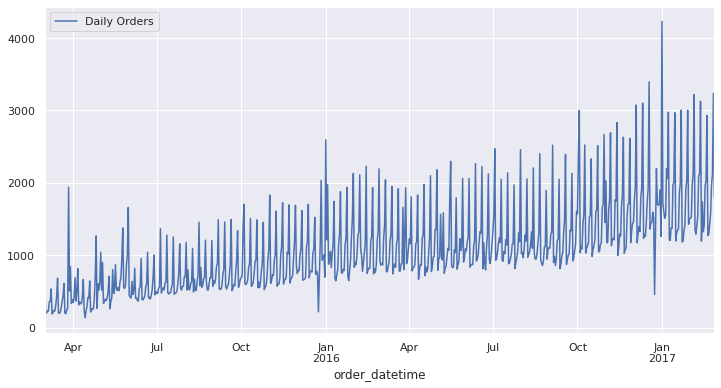

In [16]:
daily_orders.plot(
    figsize=(12,6),
#     logy=True,
    label='Daily Orders',
    legend=True,
);

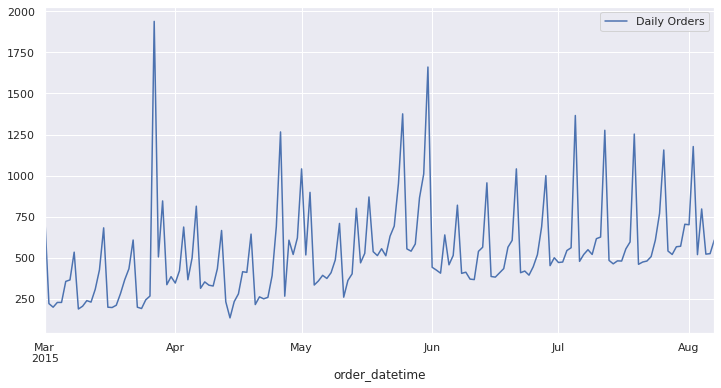

In [17]:
daily_orders['2015-03-01':'2015-08-07'].plot(
    figsize=(12,6),
#     logy=True,
    label='Daily Orders',
    legend=True,
);

Beside the obvious Christmas and New Year's Eve anomalies,
I zoomed in onto the April-May period, which looks a bit funky.
This is a probable sign of several holidays in this time period,
which might hint at the fact the we are looking at a EU country
(several EU countries happen to have a concentration of holidays
within this time frame).

Without knowing the country we are looking at
(assuming the synthetic data represents one correctly)
it is very difficult to use holidays information.
For the sake of time I will stick with Christmas and New Years' only.

#### Hourly orders

In [18]:
hourly_orders = orders_table.set_index('order_datetime')['customer_id'].resample('H').count()
hourly_orders

order_datetime
2015-03-01 00:00:00      3
2015-03-01 01:00:00      1
2015-03-01 02:00:00      1
2015-03-01 03:00:00      1
2015-03-01 04:00:00      0
                      ... 
2017-02-27 19:00:00    308
2017-02-27 20:00:00    234
2017-02-27 21:00:00    156
2017-02-27 22:00:00     55
2017-02-27 23:00:00     23
Freq: H, Name: customer_id, Length: 17520, dtype: int64

In [19]:
hourly_orders.describe()

count    17520.000000
mean        44.894235
std         71.412816
min          0.000000
25%          1.000000
50%         15.000000
75%         56.000000
max        756.000000
Name: customer_id, dtype: float64

By looking at a 2-week period around 2017-01-01 we can observe the daily seasonality
and the anomalies of holidays (25th, 31th) in more detail:

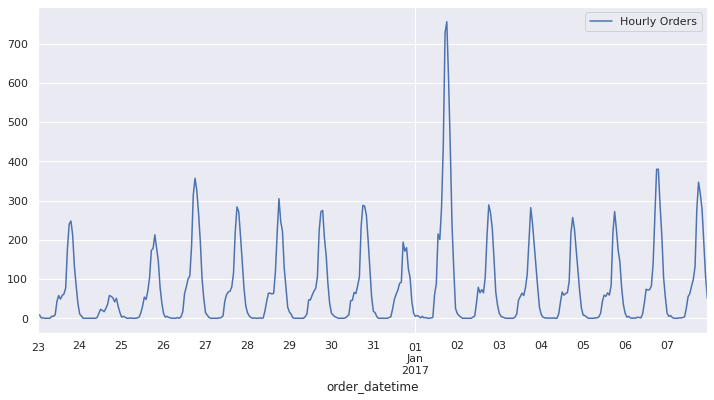

In [20]:
hourly_orders['2016-12-23':'2017-01-07'].plot(
    figsize=(12,6),
#     logy=True,
    label='Hourly Orders',
    legend=True,
);

#### Intra-day seasonality

Seasonality patterns could produce meaningful predictive features.
Here's how many orders we have in total for each hour of the day:

In [21]:
total_orders_per_hour = orders_table.groupby(orders_table['order_datetime'].dt.time)['customer_id'].count()

In [22]:
total_orders_per_hour

order_datetime
00:00:00      4627
01:00:00      2425
02:00:00      1187
03:00:00       443
04:00:00       137
05:00:00        62
06:00:00        83
07:00:00       158
08:00:00       456
09:00:00      1239
10:00:00      4319
11:00:00     19062
12:00:00     29147
13:00:00     31103
14:00:00     30319
15:00:00     34283
16:00:00     48872
17:00:00     90775
18:00:00    129647
19:00:00    134025
20:00:00    108732
21:00:00     68216
22:00:00     33398
23:00:00     13832
Name: customer_id, dtype: int64

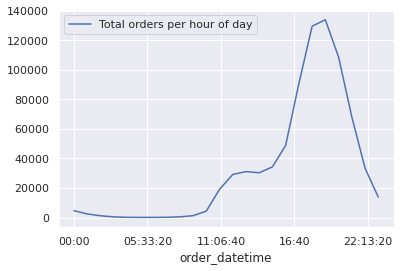

In [23]:
total_orders_per_hour.plot(label="Total orders per hour of day", legend=True);

#### Time-based features

This visualization shows how the distribution of orders is bimodal,
with one peak centered around 13:00 (lunch) and a second centered around 19:00 (dinner).
Using the hour of the day as a feature should capture this information.

Other information that can be extracted and used as a feature is:
- which day of the week an order was submitted;
- was the order day a holiday (25/12, 31/12, 01/12);
- how long ago was the last order of the customer
  (Assuming that the last data point is the "present");
- how long ago was the first order of the customer;

In [24]:
orders_features['hour_of_day'] = orders_table['order_datetime'].dt.hour

In [25]:
orders_features['day_of_week'] = orders_table['order_datetime'].dt.dayofweek

In [26]:
orders_features['is_holiday'] = (
    (
        (orders_table['order_datetime'].dt.month == 1) & (orders_table['order_datetime'].dt.day == 1)
    ) | (
        (orders_table['order_datetime'].dt.month == 12) & ((orders_table['order_datetime'].dt.day == 25) | (orders_table['order_datetime'].dt.day == 31))
    )
)

In [27]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  786547 non-null  object
 1   hour_of_day  786547 non-null  int64 
 2   day_of_week  786547 non-null  int64 
 3   is_holiday   786547 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 18.8+ MB


#### Dummy variables

Let's produce dummy variables from these:

In [28]:
col_name = 'hour_of_day'
hour_dummies = pd.get_dummies(
    orders_features[col_name],
    prefix=col_name,
)

In [29]:
orders_features[hour_dummies.columns] = hour_dummies

In [30]:
col_name = 'day_of_week'
day_of_week_dummies = pd.get_dummies(
    orders_features[col_name],
    prefix=col_name,
)

In [31]:
orders_features[day_of_week_dummies.columns] = day_of_week_dummies

In [32]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   customer_id     786547 non-null  object
 1   hour_of_day     786547 non-null  int64 
 2   day_of_week     786547 non-null  int64 
 3   is_holiday      786547 non-null  bool  
 4   hour_of_day_0   786547 non-null  uint8 
 5   hour_of_day_1   786547 non-null  uint8 
 6   hour_of_day_2   786547 non-null  uint8 
 7   hour_of_day_3   786547 non-null  uint8 
 8   hour_of_day_4   786547 non-null  uint8 
 9   hour_of_day_5   786547 non-null  uint8 
 10  hour_of_day_6   786547 non-null  uint8 
 11  hour_of_day_7   786547 non-null  uint8 
 12  hour_of_day_8   786547 non-null  uint8 
 13  hour_of_day_9   786547 non-null  uint8 
 14  hour_of_day_10  786547 non-null  uint8 
 15  hour_of_day_11  786547 non-null  uint8 
 16  hour_of_day_12  786547 non-null  uint8 
 17  hour_of_day_13  786547 non-nu

In [33]:
last_orders = orders_table.groupby('customer_id')['order_datetime'].max()
max_datetime = orders_table['order_datetime'].max()
max_datetime

Timestamp('2017-02-27 23:00:00')

In [34]:
customer_features['last_order_age_days'] = (max_datetime - last_orders).dt.days

In [35]:
first_orders = orders_table.groupby('customer_id')['order_datetime'].min()

In [36]:
customer_features['first_order_age_days'] = (max_datetime - first_orders).dt.days

In [37]:
customer_features.head()

,last_order_age_days,first_order_age_days
customer_id,,
000097eabfd9,618,618
0000e2c6d9be,395,395
000133bb597f,1,1
00018269939b,22,22
0001a00468a6,573,573


### Number of orders

We'll throw in the number of orders per customer as well:

In [38]:
number_of_orders_per_customer = orders_table.groupby('customer_id')['amount_paid'].count()
number_of_orders_per_customer.name = 'n_orders'

In [39]:
customer_features = customer_features.join(number_of_orders_per_customer)
customer_features.head()

,last_order_age_days,first_order_age_days,n_orders
customer_id,,,
000097eabfd9,618,618,1
0000e2c6d9be,395,395,1
000133bb597f,1,1,1
00018269939b,22,22,1
0001a00468a6,573,573,1


### Customer order rank

The customer order rank can show us how many orders a customer has
successfully submitted in the considered time frame.
We find this by taking the maximum of the quantity.

In [40]:
max_customer_order_rank = orders_table.groupby(
    'customer_id'
)['customer_order_rank'].max().sort_values(ascending=False)
max_customer_order_rank

customer_id
15edce943edd    369
8745a335e9cf    281
d956116d863d    272
0063666607bb    266
ae60dce05485    266
               ... 
4d262f1d2382      0
c0a84c0ffb7a      0
2cab60314f16      0
570d64fd10ed      0
7c0e6c387d48      0
Name: customer_order_rank, Length: 245453, dtype: int64

In [41]:
max_customer_order_rank.describe()

count    245453.000000
mean          3.103771
std           6.770718
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         369.000000
Name: customer_order_rank, dtype: float64

In [42]:
max_customer_order_rank.quantile(.99)

31.0

As we can see, 99% or customers haven't ordered more than 31 times,
and the majority haven't ordered more than one.

In [43]:
max_customer_order_rank.name = 'max_customer_order_rank'
customer_features = customer_features.join(max_customer_order_rank)
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   last_order_age_days      245453 non-null  int64
 1   first_order_age_days     245453 non-null  int64
 2   n_orders                 245453 non-null  int64
 3   max_customer_order_rank  245453 non-null  int64
dtypes: int64(4)
memory usage: 19.4+ MB


### is_failed

Here we can see how many orders have failed.
Using the number of orders we can also calculate a rate of success.

In [44]:
failed_orders_per_customer = orders_table.groupby('customer_id')['is_failed'].sum()
failed_orders_per_customer.name = 'n_failed'

In [45]:
failed_orders_per_customer.head()

customer_id
000097eabfd9    0
0000e2c6d9be    0
000133bb597f    0
00018269939b    0
0001a00468a6    0
Name: n_failed, dtype: int64

In [46]:
customer_features = customer_features.join(failed_orders_per_customer)
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   last_order_age_days      245453 non-null  int64
 1   first_order_age_days     245453 non-null  int64
 2   n_orders                 245453 non-null  int64
 3   max_customer_order_rank  245453 non-null  int64
 4   n_failed                 245453 non-null  int64
dtypes: int64(5)
memory usage: 21.2+ MB


### Voucher amount

We can extract the number of vouchers used, the total amount from vouchers,
and the maximum value of a customer's voucher.

In [47]:
max_voucher_amount = orders_table.groupby('customer_id')['voucher_amount'].max()
max_voucher_amount.name = 'max_voucher_amount'

In [48]:
max_voucher_amount.describe()

count    245453.000000
mean          0.171549
std           0.717387
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          93.398900
Name: max_voucher_amount, dtype: float64

In [49]:
max_voucher_amount.quantile(.9999)

16.102162439983935

In [50]:
customer_features = customer_features.join(max_voucher_amount)
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   last_order_age_days      245453 non-null  int64  
 1   first_order_age_days     245453 non-null  int64  
 2   n_orders                 245453 non-null  int64  
 3   max_customer_order_rank  245453 non-null  int64  
 4   n_failed                 245453 non-null  int64  
 5   max_voucher_amount       245453 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 23.1+ MB


In [51]:
tot_voucher_amount = orders_table.groupby('customer_id')['voucher_amount'].sum()
tot_voucher_amount.name = 'tot_voucher_amount'

In [52]:
tot_voucher_amount.describe()

count    245453.000000
mean          0.293150
std           1.824942
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         191.994250
Name: tot_voucher_amount, dtype: float64

In [53]:
customer_features = customer_features.join(tot_voucher_amount)
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   last_order_age_days      245453 non-null  int64  
 1   first_order_age_days     245453 non-null  int64  
 2   n_orders                 245453 non-null  int64  
 3   max_customer_order_rank  245453 non-null  int64  
 4   n_failed                 245453 non-null  int64  
 5   max_voucher_amount       245453 non-null  float64
 6   tot_voucher_amount       245453 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 25.0+ MB


In [54]:
n_vouchers = (orders_table['voucher_amount']>0).groupby(orders_table['customer_id']).sum()
n_vouchers.name = 'n_vouchers'

In [55]:
n_vouchers.describe()

count    245453.000000
mean          0.175728
std           1.024720
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: n_vouchers, dtype: float64

In [56]:
customer_features = customer_features.join(n_vouchers)

In [57]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   last_order_age_days      245453 non-null  int64  
 1   first_order_age_days     245453 non-null  int64  
 2   n_orders                 245453 non-null  int64  
 3   max_customer_order_rank  245453 non-null  int64  
 4   n_failed                 245453 non-null  int64  
 5   max_voucher_amount       245453 non-null  float64
 6   tot_voucher_amount       245453 non-null  float64
 7   n_vouchers               245453 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 26.9+ MB


### Delivery fee

here we follow an identical procedure as for vouchers.

In [58]:
tot_delivery_fee = orders_table.groupby('customer_id')['delivery_fee'].sum()
max_delivery_fee = orders_table.groupby('customer_id')['delivery_fee'].max()
# How many times a delivery fee was paid
n_delivery_fee = (orders_table['delivery_fee']>0).groupby(orders_table['customer_id']).sum()

In [59]:
tot_delivery_fee.name = 'tot_delivery_fee'
max_delivery_fee.name = 'max_delivery_fee'
n_delivery_fee.name = 'n_delivery_fee'

In [60]:
customer_features = customer_features.join(tot_delivery_fee)
customer_features = customer_features.join(max_delivery_fee)
customer_features = customer_features.join(n_delivery_fee)
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   last_order_age_days      245453 non-null  int64  
 1   first_order_age_days     245453 non-null  int64  
 2   n_orders                 245453 non-null  int64  
 3   max_customer_order_rank  245453 non-null  int64  
 4   n_failed                 245453 non-null  int64  
 5   max_voucher_amount       245453 non-null  float64
 6   tot_voucher_amount       245453 non-null  float64
 7   n_vouchers               245453 non-null  int64  
 8   tot_delivery_fee         245453 non-null  float64
 9   max_delivery_fee         245453 non-null  float64
 10  n_delivery_fee           245453 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 32.5+ MB


### Amount paid

Here we can use the average amount paid on top of everything else.

In [61]:
tot_amount_paid = orders_table.groupby('customer_id')['amount_paid'].sum()
avg_amount_paid = orders_table.groupby('customer_id')['amount_paid'].mean()
max_amount_paid = orders_table.groupby('customer_id')['amount_paid'].max()
min_amount_paid = orders_table.groupby('customer_id')['amount_paid'].min()

In [62]:
tot_amount_paid.name = 'tot_amount_paid'
avg_amount_paid.name = 'avg_amount_paid'
max_amount_paid.name = 'max_amount_paid'
min_amount_paid.name = 'min_amount_paid'

In [63]:
customer_features = customer_features.join(tot_amount_paid)
customer_features = customer_features.join(avg_amount_paid)
customer_features = customer_features.join(max_amount_paid)
customer_features = customer_features.join(min_amount_paid)

In [64]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   last_order_age_days      245453 non-null  int64  
 1   first_order_age_days     245453 non-null  int64  
 2   n_orders                 245453 non-null  int64  
 3   max_customer_order_rank  245453 non-null  int64  
 4   n_failed                 245453 non-null  int64  
 5   max_voucher_amount       245453 non-null  float64
 6   tot_voucher_amount       245453 non-null  float64
 7   n_vouchers               245453 non-null  int64  
 8   tot_delivery_fee         245453 non-null  float64
 9   max_delivery_fee         245453 non-null  float64
 10  n_delivery_fee           245453 non-null  int64  
 11  tot_amount_paid          245453 non-null  float64
 12  avg_amount_paid          245453 non-null  float64
 13  max_amount_paid          245453 non-null  float

### Restaurant ID

Categorical variables lend themselves naturally to produce dummy variables.

In [65]:
n_restaurants = orders_table.groupby('customer_id')['restaurant_id'].nunique()
n_restaurants.name = 'n_restaurants'
n_restaurants

customer_id
000097eabfd9    1
0000e2c6d9be    1
000133bb597f    1
00018269939b    1
0001a00468a6    1
               ..
fffd696eaedd    1
fffe9d5a8d41    2
ffff347c3cfa    2
ffff4519b52d    1
ffffccbfc8a4    1
Name: n_restaurants, Length: 245453, dtype: int64

In [66]:
n_restaurants.describe()

count    245453.000000
mean          1.760740
std           1.843813
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          51.000000
Name: n_restaurants, dtype: float64

In [67]:
customer_features = customer_features.join(n_restaurants)
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   last_order_age_days      245453 non-null  int64  
 1   first_order_age_days     245453 non-null  int64  
 2   n_orders                 245453 non-null  int64  
 3   max_customer_order_rank  245453 non-null  int64  
 4   n_failed                 245453 non-null  int64  
 5   max_voucher_amount       245453 non-null  float64
 6   tot_voucher_amount       245453 non-null  float64
 7   n_vouchers               245453 non-null  int64  
 8   tot_delivery_fee         245453 non-null  float64
 9   max_delivery_fee         245453 non-null  float64
 10  n_delivery_fee           245453 non-null  int64  
 11  tot_amount_paid          245453 non-null  float64
 12  avg_amount_paid          245453 non-null  float64
 13  max_amount_paid          245453 non-null  float

#### Dummy variables

In [68]:
col_name = 'restaurant_id'
rest_id_dummies = pd.get_dummies(
    orders_table[col_name],
    prefix=col_name,
    sparse=True,
)

In [69]:
rest_id_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 13569 entries, restaurant_id_73498 to restaurant_id_340453498
dtypes: Sparse[uint8, 0](13569)
memory usage: 3.8 MB


In [70]:
orders_features[rest_id_dummies.columns] = rest_id_dummies

In [71]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 13604 entries, customer_id to restaurant_id_340453498
dtypes: Sparse[uint8, 0](13569), bool(1), int64(2), object(1), uint8(31)
memory usage: 45.8+ MB


In [72]:
orders_features.head()

,customer_id,hour_of_day,day_of_week,is_holiday,hour_of_day_0,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,...,restaurant_id_339593498,restaurant_id_339713498,restaurant_id_339763498,restaurant_id_339773498,restaurant_id_339823498,restaurant_id_339913498,restaurant_id_339983498,restaurant_id_340033498,restaurant_id_340093498,restaurant_id_340453498
0,000097eabfd9,19,5,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0000e2c6d9be,20,4,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000133bb597f,19,6,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00018269939b,17,6,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0001a00468a6,19,1,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### City ID

In [73]:
n_cities = orders_table.groupby('customer_id')['city_id'].nunique()
n_cities.name = 'n_cities'
n_cities

customer_id
000097eabfd9    1
0000e2c6d9be    1
000133bb597f    1
00018269939b    1
0001a00468a6    1
               ..
fffd696eaedd    1
fffe9d5a8d41    1
ffff347c3cfa    1
ffff4519b52d    1
ffffccbfc8a4    1
Name: n_cities, Length: 245453, dtype: int64

In [74]:
n_cities.describe()

count    245453.000000
mean          1.044888
std           0.263277
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          26.000000
Name: n_cities, dtype: float64

In [75]:
customer_features = customer_features.join(n_cities)

In [76]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245453 entries, 000097eabfd9 to ffffccbfc8a4
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   last_order_age_days      245453 non-null  int64  
 1   first_order_age_days     245453 non-null  int64  
 2   n_orders                 245453 non-null  int64  
 3   max_customer_order_rank  245453 non-null  int64  
 4   n_failed                 245453 non-null  int64  
 5   max_voucher_amount       245453 non-null  float64
 6   tot_voucher_amount       245453 non-null  float64
 7   n_vouchers               245453 non-null  int64  
 8   tot_delivery_fee         245453 non-null  float64
 9   max_delivery_fee         245453 non-null  float64
 10  n_delivery_fee           245453 non-null  int64  
 11  tot_amount_paid          245453 non-null  float64
 12  avg_amount_paid          245453 non-null  float64
 13  max_amount_paid          245453 non-null  float

#### Dummy vars

In [77]:
col_name = 'city_id'
city_id_dummies = pd.get_dummies(
    orders_table[col_name],
    prefix=col_name,
    sparse=True,
)

In [78]:
city_id_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 3749 entries, city_id_230 to city_id_100205
dtypes: Sparse[uint8, 0](3749)
memory usage: 3.8 MB


In [79]:
orders_features[city_id_dummies.columns] = city_id_dummies

In [80]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 17353 entries, customer_id to city_id_100205
dtypes: Sparse[uint8, 0](17318), bool(1), int64(2), object(1), uint8(31)
memory usage: 49.5+ MB


### Payment ID

In [81]:
col_name = 'payment_id'
payment_id_dummies = pd.get_dummies(
    orders_table[col_name],
    prefix=col_name,
    sparse=True,
)

In [82]:
payment_id_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype           
---  ------           --------------   -----           
 0   payment_id_1491  786547 non-null  Sparse[uint8, 0]
 1   payment_id_1523  786547 non-null  Sparse[uint8, 0]
 2   payment_id_1619  786547 non-null  Sparse[uint8, 0]
 3   payment_id_1779  786547 non-null  Sparse[uint8, 0]
 4   payment_id_1811  786547 non-null  Sparse[uint8, 0]
dtypes: Sparse[uint8, 0](5)
memory usage: 3.8 MB


In [83]:
orders_features[payment_id_dummies.columns] = payment_id_dummies

In [84]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 17358 entries, customer_id to payment_id_1811
dtypes: Sparse[uint8, 0](17323), bool(1), int64(2), object(1), uint8(31)
memory usage: 53.3+ MB


### Platform ID

In [85]:
col_name = 'platform_id'
platform_id_dummies = pd.get_dummies(
    orders_table[col_name],
    prefix=col_name,
    sparse=True,
)

In [86]:
platform_id_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype           
---  ------             --------------   -----           
 0   platform_id_525    786547 non-null  Sparse[uint8, 0]
 1   platform_id_22167  786547 non-null  Sparse[uint8, 0]
 2   platform_id_22263  786547 non-null  Sparse[uint8, 0]
 3   platform_id_22295  786547 non-null  Sparse[uint8, 0]
 4   platform_id_29463  786547 non-null  Sparse[uint8, 0]
 5   platform_id_29495  786547 non-null  Sparse[uint8, 0]
 6   platform_id_29751  786547 non-null  Sparse[uint8, 0]
 7   platform_id_29815  786547 non-null  Sparse[uint8, 0]
 8   platform_id_30135  786547 non-null  Sparse[uint8, 0]
 9   platform_id_30199  786547 non-null  Sparse[uint8, 0]
 10  platform_id_30231  786547 non-null  Sparse[uint8, 0]
 11  platform_id_30359  786547 non-null  Sparse[uint8, 0]
 12  platform_id_30391  786547 non-null  Sparse[uint8, 0]
 13  platform_id_30

In [87]:
orders_features[platform_id_dummies.columns] = platform_id_dummies

In [88]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 17372 entries, customer_id to platform_id_30423
dtypes: Sparse[uint8, 0](17337), bool(1), int64(2), object(1), uint8(31)
memory usage: 57.0+ MB


### Transmission ID

In [89]:
col_name = 'transmission_id'
transmission_id_dummies = pd.get_dummies(
    orders_table[col_name],
    prefix=col_name,
    sparse=True,
)

In [90]:
transmission_id_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype           
---  ------                 --------------   -----           
 0   transmission_id_212    786547 non-null  Sparse[uint8, 0]
 1   transmission_id_1988   786547 non-null  Sparse[uint8, 0]
 2   transmission_id_2020   786547 non-null  Sparse[uint8, 0]
 3   transmission_id_4196   786547 non-null  Sparse[uint8, 0]
 4   transmission_id_4228   786547 non-null  Sparse[uint8, 0]
 5   transmission_id_4260   786547 non-null  Sparse[uint8, 0]
 6   transmission_id_4324   786547 non-null  Sparse[uint8, 0]
 7   transmission_id_4356   786547 non-null  Sparse[uint8, 0]
 8   transmission_id_4996   786547 non-null  Sparse[uint8, 0]
 9   transmission_id_21124  786547 non-null  Sparse[uint8, 0]
dtypes: Sparse[uint8, 0](10)
memory usage: 3.8 MB


In [91]:
orders_features[transmission_id_dummies.columns] = transmission_id_dummies

In [92]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 17382 entries, customer_id to transmission_id_21124
dtypes: Sparse[uint8, 0](17347), bool(1), int64(2), object(1), uint8(31)
memory usage: 60.8+ MB


### Store data

This time a space-efficient format is preferrable.

In [97]:
customer_features

,last_order_age_days,first_order_age_days,n_orders,max_customer_order_rank,n_failed,max_voucher_amount,tot_voucher_amount,n_vouchers,tot_delivery_fee,max_delivery_fee,n_delivery_fee,tot_amount_paid,avg_amount_paid,max_amount_paid,min_amount_paid,n_restaurants,n_cities
customer_id,,,,,,,,,,,,,,,,,
000097eabfd9,618,618,1,1,0,0.0,0.0,0,0.0000,0.0000,0,11.46960,11.46960,11.46960,11.46960,1,1
0000e2c6d9be,395,395,1,1,0,0.0,0.0,0,0.0000,0.0000,0,9.55800,9.55800,9.55800,9.55800,1,1
000133bb597f,1,1,1,1,0,0.0,0.0,0,0.4930,0.4930,1,5.93658,5.93658,5.93658,5.93658,1,1
00018269939b,22,22,1,1,0,0.0,0.0,0,0.4930,0.4930,1,9.82350,9.82350,9.82350,9.82350,1,1
0001a00468a6,573,573,1,1,0,0.0,0.0,0,0.4930,0.4930,1,5.15070,5.15070,5.15070,5.15070,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffd696eaedd,532,532,1,1,0,0.0,0.0,0,1.4297,1.4297,1,24.13395,24.13395,24.13395,24.13395,1,1
fffe9d5a8d41,150,211,3,1,2,0.0,0.0,0,0.0000,0.0000,0,29.89530,9.96510,10.72620,8.44290,2,1
ffff347c3cfa,165,194,2,2,0,0.0,0.0,0,0.0000,0.0000,0,13.54050,6.77025,7.59330,5.94720,2,1


### Customer features from dummy features

Here we distill the extracted order feature to customer features.

In [94]:
orders_features

,customer_id,hour_of_day,day_of_week,is_holiday,hour_of_day_0,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,...,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,19,5,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0000e2c6d9be,20,4,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,000133bb597f,19,6,False,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,00018269939b,17,6,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0001a00468a6,19,1,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786542,fffe9d5a8d41,20,4,False,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
786543,ffff347c3cfa,21,2,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
786544,ffff347c3cfa,21,3,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
786545,ffff4519b52d,19,5,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [95]:
orders_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786547 entries, 0 to 786546
Columns: 17382 entries, customer_id to transmission_id_21124
dtypes: Sparse[uint8, 0](17347), bool(1), int64(2), object(1), uint8(31)
memory usage: 60.8+ MB


In [99]:
# orders_features_dummy = orders_features.drop(
#     columns=['hour_of_day', 'day_of_week']
# ).groupby(['customer_id']).agg(np.sum)